In [ ]:
!pip install torch torchvision pyro-ppl

#import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import pyro
import pyro.distributions as dist
from pyro.distributions import Normal
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

print("Currently using Pyro version: " + pyro.__version__)

Currently using Pyro version: 1.7.0


In [ ]:
# ----------------------------------------------------- One Emotion Model [Reference]--------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# data location
#dataset_path = os.path.join(os.path.abspath('..'), "CognitionData", "data_wheelOnly.csv")
dataset_path = "https://desmond-ong.github.io/pplAffComp/CognitionData/data_wheelOnly.csv"

OUTCOME_VAR_NAMES = ["payoff1", "payoff2", "payoff3", "prob1", "prob2", "prob3", "win", "winProb", "angleProp"]
EMOTION_VAR_NAMES = ["happy", "sad", "anger", "disgust", "fear", "content", "disapp"]
OUTCOME_VAR_DIM = len(OUTCOME_VAR_NAMES)
EMOTION_VAR_DIM = len(EMOTION_VAR_NAMES)

def load_outcome_emotion_dataset(csv_file, normalize_values=True, preview_datafile=False):
    data_readin = pd.read_csv(csv_file)
    outcome_data = data_readin.loc[:,OUTCOME_VAR_NAMES]
    if normalize_values:
        ####
        ## payoff1, payoff2, payoff3 and win are between 0 and 100
        ## need to normalize to [0,1] to match the rest of the variables,
        ## by dividing payoff1, payoff2, payoff3 and win by 100
        ####
        outcome_data.loc[:,"payoff1"] = outcome_data.loc[:,"payoff1"]/100
        outcome_data.loc[:,"payoff2"] = outcome_data.loc[:,"payoff2"]/100
        outcome_data.loc[:,"payoff3"] = outcome_data.loc[:,"payoff3"]/100
        outcome_data.loc[:,"win"]     = outcome_data.loc[:,"win"]/100
    outcome_data_tensor = torch.tensor(outcome_data.values).type(torch.Tensor)
    
    emotion_data = data_readin.loc[:,EMOTION_VAR_NAMES]
    if normalize_values:
        ## note that emotions are transformed from a 9 point Likert to [0,1] via emo <- (emo-1)/8
        emotion_data   = (emotion_data-1)/8
    emotion_data_tensor = torch.tensor(emotion_data.values).type(torch.Tensor)
    
    if preview_datafile:
        print("Preview of first 3 rows:")
        print(outcome_data.loc[0:2,:])
        print(emotion_data.loc[0:2,:])
    
    data = torch.cat((outcome_data_tensor, emotion_data_tensor), 1)
    
    preprocessed_data = pd.concat([outcome_data, emotion_data], axis=1)

    shuffled_data = preprocessed_data.sample(frac=1)
    divided_parts = np.array_split(shuffled_data, 4)  

    train_set = pd.concat([divided_parts[0], divided_parts[1]], axis = 0)
    train_set = pd.concat([train_set, divided_parts[2]], axis = 0)
    test_set  = divided_parts[3] 
    
    train_set_tensor = torch.tensor(train_set.values).type(torch.Tensor)
    test_set_tensor  = torch.tensor(test_set.values).type(torch.Tensor)
    
    return train_set_tensor, test_set_tensor
    # return data


# reads in datafile.
print("Reading in dataset...")
train_set, test_set = load_outcome_emotion_dataset(csv_file=dataset_path, preview_datafile=True)
N_samples = train_set.shape[0]

print("Shape of train set: ", train_set.shape)
print("Shape of test set: ", test_set.shape)

Reading in dataset...
Preview of first 3 rows:
   payoff1  payoff2  payoff3  prob1  prob2  prob3  win  winProb  angleProp
0     0.50     0.75      0.9   0.30   0.52   0.18  0.5     0.30      0.921
1     0.15     0.70      0.8   0.45   0.29   0.26  0.8     0.26      0.873
2     0.50     0.75      0.9   0.30   0.52   0.18  0.5     0.30      0.467
   happy    sad  anger  disgust  fear  content  disapp
0  0.625  0.000  0.000     0.25   0.0    0.625   0.375
1  0.875  0.000  0.000     0.00   0.0    0.000   0.000
2  0.625  0.125  0.125     0.00   0.0    0.250   0.500
Shape of train set:  torch.Size([1156, 16])
Shape of test set:  torch.Size([385, 16])


In [ ]:
def compute_appraisal(outcome_data):
    # We have simple hard-coded appraisals, for illustration
    # This is following Ong, Zaki, & Goodman (2015)
    # the outcome data columns are, in order:
    # ["payoff1", "payoff2", "payoff3", "prob1", "prob2", "prob3", "win", "winProb", "angleProp"]
    # the 3 appraisal variables are: 
    #     amount won ("win"),
    #     Prediction Error PE = win - EV, where EV = prob1*payoff1 + prob2*payoff2 + prob3*payoff3
    #     absolute value of PE
    
    # if outcome_data only has 1 observation, reshape so vectorization works
    if(len(outcome_data.shape)==1):
        outcome_data = outcome_data.view(1,9)
        print(outcome_data.shape)
    
    # initializing appraisalVals
    appraisalVals = torch.zeros(size=(outcome_data.shape[0],3))
    appraisalVals[:,0] = outcome_data[:,6] # amount won
    
    # Expected value
    EV = outcome_data[:,0] * outcome_data[:,3] + \
         outcome_data[:,1] * outcome_data[:,4] + \
         outcome_data[:,2] * outcome_data[:,5]
    
    # prediction error and absolute PE
    appraisalVals[:,1] = appraisalVals[:,0] - EV
    appraisalVals[:,2] = abs(appraisalVals[:,1])
    return(appraisalVals)


In [ ]:
# emotion data splice dimension

# Happy           ->  OUTCOME_VAR_DIM
# Sad             ->  OUTCOME_VAR_DIM + 1
# Anger           ->  OUTCOME_VAR_DIM + 2
# Disgust         ->  OUTCOME_VAR_DIM + 3
# Fear            ->  OUTCOME_VAR_DIM + 4
# Content         ->  OUTCOME_VAR_DIM + 5
# Disappointment  ->  OUTCOME_VAR_DIM + 6

def fit_regression_model(data):
    # define the parameters that control the gaussian prior over the regression coeffs.
    # mean = 0, scale = 1
    coeff_mean_prior = torch.tensor(0.0)
    coeff_scale_prior = torch.tensor(1.0)
    
    # sample b_0 (intercept) and b_1 to b_3 (regression coeffs)
    b_0 = pyro.sample("b_0", Normal(coeff_mean_prior, coeff_scale_prior))
    b_1 = pyro.sample("b_1", Normal(coeff_mean_prior, coeff_scale_prior))
    b_2 = pyro.sample("b_2", Normal(coeff_mean_prior, coeff_scale_prior))
    b_3 = pyro.sample("b_3", Normal(coeff_mean_prior, coeff_scale_prior))
    
    # loop over observed data
    with pyro.plate("map"):
        outcome_data = data[:, :(OUTCOME_VAR_DIM)]
        # Here, for simplification, we are only taking one emotion variable (happy)
        # instead of all 8 emotions
        emotion_data = data[:, OUTCOME_VAR_DIM + 6]  
        appraisal_vars = compute_appraisal(outcome_data)
        
        # run the regression forward
        prediction = b_0 + b_1 * appraisal_vars[:,0] + b_2 * appraisal_vars[:,1] + b_3 * appraisal_vars[:,2]
        # condition on the observed data
        pyro.sample("obs", Normal(prediction, 1), obs = emotion_data)

In [ ]:
def fit_regression_guide(data):
    mean_b0_param  = pyro.param("guide_mean_b0",  torch.tensor(0.0))
    scale_b0_param = pyro.param("guide_scale_b0", torch.tensor(1.0))
    mean_b1_param  = pyro.param("guide_mean_b1",  torch.tensor(0.0))
    scale_b1_param = pyro.param("guide_scale_b1", torch.tensor(1.0))
    mean_b2_param  = pyro.param("guide_mean_b2",  torch.tensor(0.0))
    scale_b2_param = pyro.param("guide_scale_b2", torch.tensor(1.0))
    mean_b3_param  = pyro.param("guide_mean_b3",  torch.tensor(0.0))
    scale_b3_param = pyro.param("guide_scale_b3", torch.tensor(1.0))
    # sample coefficients from Normal(mean, scale)
    pyro.sample("b_0", Normal(mean_b0_param, scale_b0_param))
    pyro.sample("b_1", Normal(mean_b1_param, scale_b1_param))
    pyro.sample("b_2", Normal(mean_b2_param, scale_b2_param))
    pyro.sample("b_3", Normal(mean_b3_param, scale_b3_param))
    

In [ ]:
    def __getitem__(self, idx):
        try:
          idx = idx.item()
        except:
          idx = idx
        return self.data.iloc[idx]

[iteration 0001] loss: 3.4071
[iteration 0101] loss: 1.3019
[iteration 0201] loss: 1.0224
[iteration 0301] loss: 0.9790
[iteration 0401] loss: 1.2312
[iteration 0501] loss: 0.9615
[iteration 0601] loss: 0.9731
[iteration 0701] loss: 0.9526
[iteration 0801] loss: 0.9557
[iteration 0901] loss: 0.9637


Text(0, 0.5, 'loss')

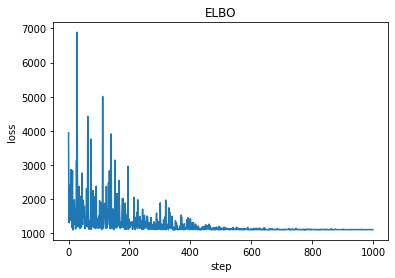

In [ ]:
# this line clears pyro's parameter store.
pyro.clear_param_store()

num_iterations = 1000

# setup the optimizer with some learning rate
optimizer = Adam({"lr": 0.005})

# setup the inference algorithm
svi = SVI(fit_regression_model, fit_regression_guide, optimizer, loss=Trace_ELBO())

# Splitting into training and testing datasets
# train_size = int(0.75 * len(outcome_emotion_dataset))
# test_size = len(outcome_emotion_dataset) - train_size
# train_dataset, test_dataset = torch.utils.data.random_split(outcome_emotion_dataset, [train_size, test_size])

# print(train_dataset.dataset)
# print(outcome_emotion_dataset)

# do gradient steps
losses = []
for thisIteration in range(num_iterations):
    # calculate the loss and take a gradient step
    thisLoss = svi.step(train_set)
    losses.append(thisLoss)
    if thisIteration % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (thisIteration + 1, thisLoss / float(N_samples)))

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")

In [ ]:
# output the learned variational parameters
print("b0 ~ Normal(%.4f, %.4f)" % (pyro.param("guide_mean_b0").item(), pyro.param("guide_scale_b0").item()))
print("b1 ~ Normal(%.4f, %.4f)" % (pyro.param("guide_mean_b1").item(), pyro.param("guide_scale_b1").item()))
print("b2 ~ Normal(%.4f, %.4f)" % (pyro.param("guide_mean_b2").item(), pyro.param("guide_scale_b2").item()))
print("b3 ~ Normal(%.4f, %.4f)" % (pyro.param("guide_mean_b3").item(), pyro.param("guide_scale_b3").item()))

b0 ~ Normal(0.2719, 0.0293)
b1 ~ Normal(-0.0508, 0.0547)
b2 ~ Normal(-1.1101, 0.1358)
b3 ~ Normal(0.4091, 0.1761)


In [ ]:
class appraisalRegressionModule(nn.Module):
    def __init__(self, num_features):
        super(appraisalRegressionModule, self).__init__()
        self.linear = nn.Linear(num_features, 1)

    def forward(self, outcome):
        return self.linear(outcome)

regression_model = appraisalRegressionModule(OUTCOME_VAR_DIM)

In [ ]:
# emotion_data splice dimension

# Happy           ->  OUTCOME_VAR_DIM
# Sad             ->  OUTCOME_VAR_DIM + 1
# Anger           ->  OUTCOME_VAR_DIM + 2
# Disgust         ->  OUTCOME_VAR_DIM + 3
# Fear            ->  OUTCOME_VAR_DIM + 4
# Content         ->  OUTCOME_VAR_DIM + 5
# Disappointment  ->  OUTCOME_VAR_DIM + 6

def bayesianRegressionModel(data):
    # Create unit normal priors over the parameters
    weights_loc   = torch.zeros(size=(torch.Size((1, OUTCOME_VAR_DIM))))
    weights_scale = torch.ones(size=(torch.Size((1, OUTCOME_VAR_DIM))))
    weights_prior = Normal(weights_loc, weights_scale).independent(1)
    
    # location and scale prior for the bias
    bias_loc   = torch.zeros(size=(torch.Size((1, ))))
    bias_scale = torch.ones(size=(torch.Size((1, ))))
    bias_prior = Normal(bias_loc, bias_scale).independent(1)
    
    priors = {'linear.weight': weights_prior, 'linear.bias': bias_prior}
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", regression_model, priors)
    # sample a model (which also samples from weights_prior and bias_prior)
    sampled_regression_model = lifted_module()
    
    with pyro.plate("map"):
        outcome_data = data[:, :(OUTCOME_VAR_DIM)]
        # Here, for simplification, we are only taking one emotion variable (happy)
        # instead of all 8 emotions
        # OUTCOME_VAR_DIM = 8 = Happy (Change the number accordingly for subsequent emotions)
        emotion_data = data[:, OUTCOME_VAR_DIM + 6]  
        
        # run the regressor forward conditioned on data
        prediction = sampled_regression_model(outcome_data).squeeze(-1)
        # condition on the observed data
        pyro.sample("obs", Normal(prediction, 1), obs = emotion_data)

In [ ]:
def bayesianRegressionGuide(data):
    # define our variational parameters
    weights_loc   = torch.randn(1, OUTCOME_VAR_DIM)
    # Note that the scale has to be non-negative. Thus, we use exp() to get a non-negative number.
    # we also use a narrower scale (exp(-1) ~ 0.35 instead of exp(0) = 1)
    weights_scale = torch.exp(-1.0 * torch.ones(1, OUTCOME_VAR_DIM) + 0.05 * torch.randn(1, OUTCOME_VAR_DIM))
    bias_loc      = torch.randn(1)
    bias_scale    = torch.exp(-1.0 * torch.ones(1) + 0.05 * torch.randn(1))

    # using pyro.param() to register the variational parameters
    weight_loc_param   = pyro.param("guide_loc_weight", weights_loc)
    weight_scale_param = pyro.param("guide_scale_weight", weights_scale)
    bias_loc_param     = pyro.param("guide_loc_bias", bias_loc)
    bias_scale_param   = pyro.param("guide_scale_bias", bias_scale)
    # guide distributions for w and b
    weight_dist = Normal(weight_loc_param, weight_scale_param).independent(1)
    bias_dist   = Normal(bias_loc_param, bias_scale_param).independent(1)
    dists = {'linear.weight': weight_dist, 'linear.bias': bias_dist}
    # lift the module and sample from that distribution
    lifted_module = pyro.random_module("module", regression_model, dists)
    return lifted_module()

[iteration 0001] loss: 2.5498


/usr/local/lib/python3.7/dist-packages/pyro/primitives.py:492: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  FutureWarning,


[iteration 0101] loss: 1.0786
[iteration 0201] loss: 1.0699
[iteration 0301] loss: 1.0650
[iteration 0401] loss: 1.0369
[iteration 0501] loss: 1.0227
[iteration 0601] loss: 1.0148
[iteration 0701] loss: 1.0090
[iteration 0801] loss: 0.9948
[iteration 0901] loss: 1.0003


Text(0, 0.5, 'loss')

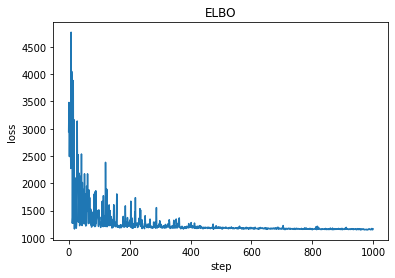

In [ ]:
pyro.clear_param_store()

num_iterations = 1000

# setup the optimizer with some learning rate
optimizer = Adam({"lr": 0.005})

# setup the inference algorithm
bayesianRegressionSVI = SVI(bayesianRegressionModel, bayesianRegressionGuide, optimizer, loss=Trace_ELBO())

# Splitting into training and testing datasets
# train_size = int(0.75 * len(outcome_emotion_dataset))
# test_size = len(outcome_emotion_dataset) - train_size
# train_dataset, test_dataset = torch.utils.data.random_split(outcome_emotion_dataset, [train_size, test_size])

# do gradient steps
losses = []
for thisIteration in range(num_iterations):
    # calculate the loss and take a gradient step
    thisLoss = bayesianRegressionSVI.step(train_set)
    losses.append(thisLoss)
    if thisIteration % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (thisIteration + 1, thisLoss / float(N_samples)))
        

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")

In [ ]:
#for name in pyro.get_param_store().get_all_param_names():
#    print(name, pyro.param(name).data.numpy())

guide_loc_weight = pyro.param("guide_loc_weight")[0]
guide_scale_weight = pyro.param("guide_scale_weight")[0]

print("b0 ~ Normal(%.4f, %.4f)" % (pyro.param("guide_loc_bias").item(), pyro.param("guide_scale_bias").item()))
for j in range(len(guide_loc_weight)):
    print("b%1d" % (j+1), "~ Normal(%.4f, %.4f)" % (guide_loc_weight[j], guide_scale_weight[j]))
    

b0 ~ Normal(-0.7716, 0.0259)
b1 ~ Normal(-0.3039, 0.0968)
b2 ~ Normal(0.9158, 0.0564)
b3 ~ Normal(1.2147, 0.0416)
b4 ~ Normal(1.1157, 0.0799)
b5 ~ Normal(-0.9618, 0.0846)
b6 ~ Normal(-0.0373, 0.1022)
b7 ~ Normal(-1.1585, 0.0398)
b8 ~ Normal(0.1713, 0.0694)
b9 ~ Normal(0.1973, 0.0544)


In [ ]:
b_0 = pyro.sample("b_0", Normal(pyro.param("guide_loc_bias").item(), pyro.param("guide_scale_bias").item()))
b_1 = pyro.sample("b_1", Normal(guide_loc_weight[0], guide_scale_weight[0]))
b_2 = pyro.sample("b_2", Normal(guide_loc_weight[1], guide_scale_weight[1]))
b_3 = pyro.sample("b_3", Normal(guide_loc_weight[2], guide_scale_weight[2]))
b_4 = pyro.sample("b_4", Normal(guide_loc_weight[3], guide_scale_weight[3]))
b_5 = pyro.sample("b_5", Normal(guide_loc_weight[4], guide_scale_weight[4]))
b_6 = pyro.sample("b_6", Normal(guide_loc_weight[5], guide_scale_weight[5]))
b_7 = pyro.sample("b_7", Normal(guide_loc_weight[6], guide_scale_weight[6]))
b_8 = pyro.sample("b_8", Normal(guide_loc_weight[7], guide_scale_weight[7]))
b_9 = pyro.sample("b_9", Normal(guide_loc_weight[8], guide_scale_weight[8]))
# print(b_0)

In [ ]:
# print(sampled_data)

In [ ]:
# new_data = [0.20,    0.60,     0.90,   0.33,   0.20,   0.47,  0.90,     0.47,      0.960]

new_predictions = []
for new_data in test_set:
  # print("New Data 9 : ", new_data[9])
  new_prediction = b_0 + b_1 * new_data[0] + b_2 * new_data[1] + b_3 * new_data[2] + b_4 * new_data[3] + b_5 * new_data[4] + b_6 * new_data[5] + b_7 * new_data[6] + b_8 * new_data[7] + b_9 * new_data[8] 
  new_predictions.append(new_prediction.item())

In [ ]:
# Dimension value for test_set to calculate average_MAE

# Happy           ->  9
# Sad             ->  10
# Anger           ->  11
# Disgust         ->  12
# Fear            ->  13
# Content         ->  14
# Disappointment  ->  15

import math

average_rmse = 0
for x in range(len(test_set)):
  average_rmse += math.sqrt(abs((math.pow(new_predictions[x], 2) - math.pow(test_set[x][15].item(), 2))))
  # print(math.sqrt(abs((math.pow(new_predictions[x], 2) - math.pow(test_dataset.dataset[x][9].item(), 2)))))

average_rmse = average_rmse/len(test_set)

print(average_rmse)
# average_MAE = average_MAE/5

# print(average_MAE)

0.38958410243688857


In [ ]:
# ------------------------------------------------- Multiple Emotions [Proposed EMPath Framework] ------------------------------------
# ---------------------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------------------

In [ ]:
!pip install torch torchvision pyro-ppl

#import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.model_selection as sk

import torch
import torch.nn as nn

import pyro
import pyro.distributions as dist
from pyro.distributions import Normal
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

print("Currently using Pyro version: " + pyro.__version__)

Currently using Pyro version: 1.7.0


In [ ]:
# data location
#dataset_path = os.path.join(os.path.abspath('..'), "CognitionData", "data_wheelOnly.csv")
dataset_path = "https://desmond-ong.github.io/pplAffComp/CognitionData/data_wheelOnly.csv"

OUTCOME_VAR_NAMES = ["payoff1", "payoff2", "payoff3", "prob1", "prob2", "prob3", "win", "winProb", "angleProp"]
EMOTION_VAR_NAMES = ["happy", "sad", "anger", "disgust", "fear", "content", "disapp"]

OUTCOME_VAR_NAMES_CONV = [0, 1, 2, 3, 4, 5, 6, 7, 8]
EMOTION_VAR_NAMES_CONV = [9, 10, 11, 12, 13, 14, 15]

OUTCOME_VAR_DIM = len(OUTCOME_VAR_NAMES)
EMOTION_VAR_DIM = len(EMOTION_VAR_NAMES)

def load_outcome_emotion_dataset(csv_file, normalize_values=True, preview_datafile=False):
    data_readin = pd.read_csv(csv_file)
    outcome_data = data_readin.loc[:,OUTCOME_VAR_NAMES]
    if normalize_values:
        ####
        ## payoff1, payoff2, payoff3 and win are between 0 and 100
        ## need to normalize to [0,1] to match the rest of the variables,
        ## by dividing payoff1, payoff2, payoff3 and win by 100
        ####
        outcome_data.loc[:,"payoff1"] = outcome_data.loc[:,"payoff1"]/100
        outcome_data.loc[:,"payoff2"] = outcome_data.loc[:,"payoff2"]/100
        outcome_data.loc[:,"payoff3"] = outcome_data.loc[:,"payoff3"]/100
        outcome_data.loc[:,"win"]     = outcome_data.loc[:,"win"]/100
    outcome_data_tensor = torch.tensor(outcome_data.values).type(torch.Tensor)
    
    emotion_data = data_readin.loc[:,EMOTION_VAR_NAMES]
    if normalize_values:
        ## note that emotions are transformed from a 9 point Likert to [0,1] via emo <- (emo-1)/8
        emotion_data   = (emotion_data-1)/8
    emotion_data_tensor = torch.tensor(emotion_data.values).type(torch.Tensor)
    
    if preview_datafile:
        print("Preview of first 3 rows:")
        print(outcome_data.loc[0:2,:])
        print(emotion_data.loc[0:2,:])
    
    data = torch.cat((outcome_data_tensor, emotion_data_tensor), 1)

    preprocessed_data = pd.concat([outcome_data, emotion_data], axis=1)

    shuffled_data = preprocessed_data.sample(frac=1)
    divided_parts = np.array_split(shuffled_data, 4)  

    train_set = pd.concat([divided_parts[0], divided_parts[1]], axis = 0)
    train_set = pd.concat([train_set, divided_parts[2]], axis = 0)
    test_set  = divided_parts[3] 
    
    # train_set_tensor = torch.tensor(train_set.values).type(torch.Tensor)
    # test_set_tensor  = torch.tensor(test_set.values).type(torch.Tensor)
    
    # return train_set, test_set
    # for part in result:
      # print(part,'\n')
    # X_train, X_test, Y_train, Y_test = sk.train_test_split(OUTCOME_VAR_NAMES,EMOTION_VAR_NAMES,test_size=0.25, random_state = 42)

    # print("X_train : ", X_train)
    # return data    
    # # Splitting into training and testing datasets
    # train_size = int(0.75 * len(data))
    # test_size = len(data) - train_size
    # train_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, test_size])

    # print(len(data))
    # print(len(train_dataset.dataset))
    # print(len(test_dataset.dataset))

    # train_dataset_pd = pd.DataFrame(train_dataset.dataset).astype("float")
    # test_dataset_pd = pd.DataFrame(test_dataset.dataset).astype("float")

    # # print(train_data)
    outcome_data_train =  train_set.loc[:,OUTCOME_VAR_NAMES]
    emotion_data_train = train_set.loc[:,EMOTION_VAR_NAMES]
    outcome_data_test = test_set.loc[:,OUTCOME_VAR_NAMES]
    emotion_data_test = test_set.loc[:,EMOTION_VAR_NAMES]

    # # return data
    return outcome_data_train, emotion_data_train, outcome_data_test, emotion_data_test

# reads in datafile.
print("Reading in dataset...")
# train_set, test_set = load_outcome_emotion_dataset(csv_file=dataset_path, preview_datafile=True)
outcome_data_train, emotion_data_train, outcome_data_test, emotion_data_test = load_outcome_emotion_dataset(csv_file=dataset_path, preview_datafile=True)


# Splitting into training and testing datasets
# train_size = int(0.75 * len(outcome_emotion_dataset))
# test_size = len(outcome_emotion_dataset) - train_size
# train_dataset, test_dataset = torch.utils.data.random_split(outcome_emotion_dataset, [train_size, test_size])

# print(len(outcome_emotion_dataset))
# print(len(train_dataset.dataset))
# print(len(test_dataset.dataset))

# train_dataset_pd = pd.DataFrame(train_dataset.dataset).astype("float")
# test_dataset_pd = pd.DataFrame(test_dataset.dataset).astype("float")

# # print(train_data)
# outcome_data_train =  train_dataset_pd.loc[:,OUTCOME_VAR_NAMES_CONV]
# emotion_data_train = train_dataset_pd.loc[:,EMOTION_VAR_NAMES_CONV]
# outcome_data_test = test_dataset_pd.loc[:,OUTCOME_VAR_NAMES_CONV]
# emotion_data_test = test_dataset_pd.loc[:,EMOTION_VAR_NAMES_CONV]


print(train_set)
# outcome_data = outcome_emotion_dataset[:, :(OUTCOME_VAR_DIM)]
# emotion_data = outcome_emotion_dataset[:, (OUTCOME_VAR_DIM):]

print("Outcome Train Set Shape : ", outcome_data_train.shape)
print("Emotion Train Set Shape : ", emotion_data_train.shape)
print("Outcome Test Set Shape : ", outcome_data_test.shape)
print("Emotion Test Set Shape : ", emotion_data_test.shape)

# N_samples = outcome_emotion_dataset.shape[0]

# print("Shape of dataset: ", outcome_emotion_dataset.shape)

Reading in dataset...
Preview of first 3 rows:
   payoff1  payoff2  payoff3  prob1  prob2  prob3  win  winProb  angleProp
0     0.50     0.75      0.9   0.30   0.52   0.18  0.5     0.30      0.921
1     0.15     0.70      0.8   0.45   0.29   0.26  0.8     0.26      0.873
2     0.50     0.75      0.9   0.30   0.52   0.18  0.5     0.30      0.467
   happy    sad  anger  disgust  fear  content  disapp
0  0.625  0.000  0.000     0.25   0.0    0.625   0.375
1  0.875  0.000  0.000     0.00   0.0    0.000   0.000
2  0.625  0.125  0.125     0.00   0.0    0.250   0.500
tensor([[0.2000, 0.4500, 0.7000,  ..., 0.1250, 0.8750, 0.1250],
        [0.5000, 0.7500, 0.9000,  ..., 0.0000, 0.0000, 0.3750],
        [0.2500, 0.6000, 1.0000,  ..., 0.3750, 0.5000, 0.6250],
        ...,
        [0.2000, 0.6000, 0.9000,  ..., 0.0000, 0.8750, 0.0000],
        [0.2000, 0.6000, 0.9000,  ..., 0.1250, 0.7500, 0.0000],
        [0.5000, 0.7500, 0.9000,  ..., 0.0000, 0.3750, 0.0000]])
Outcome Train Set Shape :  (1156, 9

In [ ]:
# sampled_data = outcome_data.loc[0:10, :]
# print(sampled_data)

In [ ]:
# sampled_target = emotion_data.loc[0:10, :]
# print(sampled_target)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from numpy import asarray

In [ ]:
def get_model(n_inputs, n_outputs):
  model = Sequential()
  model.add(Dense(320, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
  model.add(Dense(160, input_dim=320, kernel_initializer='he_uniform', activation='relu'))
  model.add(Dense(80, input_dim=160, kernel_initializer='he_uniform', activation='relu'))
  model.add(Dense(40, input_dim=80, kernel_initializer='he_uniform', activation='relu'))
  model.add(Dense(n_outputs))
  model.compile(loss='mae', optimizer='adam')
  return model

In [ ]:
from sklearn.model_selection import RepeatedKFold
from numpy import mean
from numpy import std

In [ ]:
def evaluate_model(X, y):
	results = list()
	n_inputs, n_outputs = X.shape[1], y.shape[1]
	# define evaluation procedure
	cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
	# enumerate folds
	for train_ix, test_ix in cv.split(X):
		# prepare data
    # x.iloc[list(train_index)], x.iloc[list(test_index)]
		X_train, X_test = X.iloc[list(train_ix)], X.iloc[list(test_ix)]
		y_train, y_test = y.iloc[list(train_ix)], y.iloc[list(test_ix)]
		# define model
		model = get_model(n_inputs, n_outputs)
		# fit modelb
		model.fit(X_train, y_train, verbose=0, epochs=100)
		# evaluate model on test set
		mae = model.evaluate(X_test, y_test, verbose=0)
		# store result
		print('>%.3f' % mae)
		results.append(mae)
	return results

In [ ]:
# print("Outcome Data")
# print(outcome_data)
# print(outcome_data.shape)

# print("Emotion Data")
# print(emotion_data)
# print(emotion_data.shape)

In [ ]:
# evaluate model
results = evaluate_model(outcome_data_train, emotion_data_train)
# summarize performance
print('MAE: %.3f (%.3f)' % (mean(results), std(results)))

>0.148
>0.126
>0.136
>0.132
>0.150
>0.137
>0.125
>0.132
>0.139
>0.125
>0.135
>0.140
>0.146
>0.141
>0.129
>0.135
>0.135
>0.132
>0.128
>0.124
>0.139
>0.124
>0.140
>0.148
>0.137
>0.130
>0.135
>0.130
>0.128
>0.137
MAE: 0.135 (0.007)


In [ ]:
n_inputs, n_outputs = outcome_data_train.shape[1], emotion_data_train.shape[1]
# get model
model = get_model(n_inputs, n_outputs)
# fit the model on all data
model.fit(outcome_data_train, emotion_data_train, verbose=0, epochs=100)

In [ ]:
def mood_push_and_pull(VEC_PAD, CurrentMood_PAD, push_intensity):
  
  dist_between_VEC_Current  = math.sqrt(math.pow(VEC_P - CurrentMood_PAD[0], 2) + math.pow(VEC_A - CurrentMood_PAD[1], 2) + math.pow(VEC_D - CurrentMood_PAD[2], 2))
  scale = push_intensity/dist_between_VEC_Current

  if (((VEC_PAD[0] * CurrentMood_PAD[0]) > 0) and ((VEC_PAD[1] * CurrentMood_PAD[1]) > 0) and ((VEC_PAD[2] * CurrentMood_PAD[2]) > 0) ):
    if (VEC_PAD[0] >= 0):
      if (CurrentMood_PAD[0] < VEC_PAD[0]):
        NewMood_P = CurrentMood_PAD[0] + (scale * (VEC_PAD[0] - CurrentMood_PAD[0]))
        NewMood_A = CurrentMood_PAD[1] + (scale * (VEC_PAD[1] - CurrentMood_PAD[1]))
        NewMood_D = CurrentMood_PAD[2] + (scale * (VEC_PAD[2] - CurrentMood_PAD[2]))
      else:
        NewMood_P = CurrentMood_PAD[0] + (scale * (CurrentMood_PAD[0] - VEC_PAD[0]))
        NewMood_A = CurrentMood_PAD[1] + (scale * (CurrentMood_PAD[1] - VEC_PAD[1]))
        NewMood_D = CurrentMood_PAD[2] + (scale * (CurrentMood_PAD[2] - VEC_PAD[2]))
    else:
      if (CurrentMood_PAD[0] > VEC_PAD[0]):
        NewMood_P = CurrentMood_PAD[0] + (scale * (VEC_PAD[0] - CurrentMood_PAD[0]))
        NewMood_A = CurrentMood_PAD[1] + (scale * (VEC_PAD[1] - CurrentMood_PAD[1]))
        NewMood_D = CurrentMood_PAD[2] + (scale * (VEC_PAD[2] - CurrentMood_PAD[2]))
      else:
        NewMood_P = CurrentMood_PAD[0] + (scale * (CurrentMood_PAD[0] - VEC_PAD[0]))
        NewMood_A = CurrentMood_PAD[1] + (scale * (CurrentMood_PAD[1] - VEC_PAD[1]))
        NewMood_D = CurrentMood_PAD[2] + (scale * (CurrentMood_PAD[2] - VEC_PAD[2]))
  else :   
        NewMood_P = CurrentMood_PAD[0] + (scale * (VEC_PAD[0] - CurrentMood_PAD[0]))
        NewMood_A = CurrentMood_PAD[1] + (scale * (VEC_PAD[1] - CurrentMood_PAD[1]))
        NewMood_D = CurrentMood_PAD[2] + (scale * (VEC_PAD[2] - CurrentMood_PAD[2]))

  NewMood_PAD = [NewMood_P, NewMood_A, NewMood_D]
  return NewMood_PAD

In [ ]:
# Concatenating Prediction + EMP Cycle in One Cell for looped predictions
# print(outcome_data_test)
outcome_data_test_arr = np.asarray(outcome_data_test)
emotion_data_test_arr = np.asarray(emotion_data_test)

final_emp_outcomes = []

for target in outcome_data_test_arr:
  # print(target)
  newTarget = asarray([target])
  yhat = model.predict(newTarget)
  prediction = yhat[0]
  # print('Predicted: %s' % yhat[0])

  # Defining a character's personality based on the Big Five Personality Model
  Openness = 0.4
  Conscientiousness = 0.8
  Extraversion = 0.6
  Agreeableness = 0.3
  Neuroticism = 0.4

  # Since, we do not have information about the participants in the trial. We assume that on an average the peope were in a slightly relaxed default mood.
  # The personality traits chosen are hence so. 

  # Calculating default mood in the PAD space based on the above peronality characteristics
  Pleasure  = (0.21 * Extraversion) + (0.59 * Agreeableness)        + (0.19 * Neuroticism)
  Arousal   = (0.15 * Openness)     + (0.30 * Agreeableness)        - (0.57 * Neuroticism)
  Dominance = (0.25 * Openness)     + (0.17 * Conscientiousness)    + (0.60 * Extraversion)     - (0.32 * Agreeableness) 

  DefaultMood_PAD = [Pleasure, Arousal, Dominance]


  # PAD Mappings for Emotions
  # Mappings were not available for all emotions in the dataset. The emotions which were nearest in meaning and had mappings available were thus chosen.
  # Except Surprise, we could find alternatives for every other emotion. As a result Surprise was dropped from the dataset and thus the predictions.

  # Emotion (Dataset) <-------> Mapped Emotion in PAD Space
  # Happy             -         Joy
  # Sad               -         Remorse
  # Anger             -         Anger
  # Disgust           -         Shame
  # Fear              -         Fear
  # Content           -         Gratification
  # Disappointment    -         Disappointment

  Happy_Intensity              = prediction[0] if (prediction[0] > 0) else 0.0
  Sad_Intensity                = prediction[1] if (prediction[1] > 0) else 0.0
  Anger_Intensity              = prediction[2] if (prediction[2] > 0) else 0.0
  Disgust_Intensity            = prediction[3] if (prediction[3] > 0) else 0.0
  Fear_Intensity               = prediction[4] if (prediction[4] > 0) else 0.0
  Content_Intensity            = prediction[5] if (prediction[5] > 0) else 0.0
  Disappointment_Intensity     = prediction[6] if (prediction[6] > 0) else 0.0

  Happy_PAD           = [0.4, 0.2, -0.3]
  Sad_PAD             = [-0.3, 0.1, -0.6]
  Anger_PAD           = [-0.51, 0.59, 0.25]
  Disgust_PAD         = [-0.3, 0.1, -0.6]
  Fear_PAD            = [-0.64, 0.60, -0.43]
  Content_PAD         = [0.6, 0.5, 0.4]
  Disappointment_PAD  = [-0.3, 0.1, -0.4]

  Appraised_Intensities = [Happy_Intensity, Sad_Intensity, Anger_Intensity, Disgust_Intensity, Fear_Intensity, Content_Intensity, Disappointment_Intensity]
  Mapped_Emotions       = [Happy_PAD, Sad_PAD, Anger_PAD, Disgust_PAD, Fear_PAD, Content_PAD, Disappointment_PAD]

  # Calculating Virtual Emotion Centre
  Summation_Intensities = Happy_Intensity + Sad_Intensity + Anger_Intensity + Disgust_Intensity + Fear_Intensity + Content_Intensity + Disappointment_Intensity

  VEC_P   = ( (Happy_Intensity * Happy_PAD[0]) + (Sad_Intensity * Sad_PAD[0]) + (Anger_Intensity * Anger_PAD[0]) + (Disgust_Intensity * Disgust_PAD[0]) + (Fear_Intensity * Fear_PAD[0]) + (Content_Intensity * Content_PAD[0]) + (Disappointment_Intensity * Disappointment_PAD[0])) / Summation_Intensities
  VEC_A   = ( (Happy_Intensity * Happy_PAD[1]) + (Sad_Intensity * Sad_PAD[1]) + (Anger_Intensity * Anger_PAD[1]) + (Disgust_Intensity * Disgust_PAD[1]) + (Fear_Intensity * Fear_PAD[1]) + (Content_Intensity * Content_PAD[1]) + (Disappointment_Intensity * Disappointment_PAD[1])) / Summation_Intensities
  VEC_D   = ( (Happy_Intensity * Happy_PAD[2]) + (Sad_Intensity * Sad_PAD[2]) + (Anger_Intensity * Anger_PAD[2]) + (Disgust_Intensity * Disgust_PAD[2]) + (Fear_Intensity * Fear_PAD[2]) + (Content_Intensity * Content_PAD[2]) + (Disappointment_Intensity * Disappointment_PAD[2])) / Summation_Intensities

  VEC_PAD = [VEC_P, VEC_A, VEC_D]
  # print("Virtual Emotion Centre : ", VEC_PAD)

  CurrentMood_PAD = DefaultMood_PAD
  push_intensity = Summation_Intensities/7.0
  NewMood_PAD = mood_push_and_pull(VEC_PAD, CurrentMood_PAD, push_intensity)

  # Per Emotion Regulation 
  # P_Val = 1 if (Happy_PAD[0] * NewMood_PAD[0]) > 0 else -1
  # A_Val = 1 if (Happy_PAD[1] * NewMood_PAD[1]) > 0 else -1
  # D_Val = 1 if (Happy_PAD[2] * NewMood_PAD[2]) > 0 else -1

  # New_Happy_P = Happy_PAD[0] * (1 + (0.25 * P_Val * NewMood_PAD[0]))
  # New_Happy_A = Happy_PAD[1] * (1 + (0.25 * A_Val * NewMood_PAD[1]))
  # New_Happy_D = Happy_PAD[2] * (1 + (0.25 * D_Val * NewMood_PAD[2]))

  # New_Happy_PAD = [New_Happy_P, New_Happy_A, New_Happy_D]


  # All emotions are regulated based on the valence value
  New_Generated_Emotions = []

  for emotion in Mapped_Emotions:
    P_Val = 1 if (emotion[0] * NewMood_PAD[0]) > 0 else -1
    A_Val = 1 if (emotion[1] * NewMood_PAD[1]) > 0 else -1
    D_Val = 1 if (emotion[2] * NewMood_PAD[2]) > 0 else -1

    New_Emotion_P = emotion[0] * (1 + (0.25 * P_Val * NewMood_PAD[0]))
    New_Emotion_A = emotion[1] * (1 + (0.25 * A_Val * NewMood_PAD[1]))
    New_Emotion_D = emotion[2] * (1 + (0.25 * D_Val * NewMood_PAD[2]))

    New_Emotion_PAD = [New_Emotion_P, New_Emotion_A, New_Emotion_D]
    New_Generated_Emotions.append(New_Emotion_PAD)
  
  Final_Intensities_Generated = []

  Original_Emotion_Norms = []
  New_Emotion_Norms =[]

  # Calculating Norm for Original PADs 
  for emotion in Mapped_Emotions:
    emotion_norm = math.sqrt(math.pow(emotion[0], 2) + math.pow(emotion[1], 2) + math.pow(emotion[2], 2))
    Original_Emotion_Norms.append(emotion_norm)

  # Calculating Norm for Newly Generated PADs 
  for new_emotion in New_Generated_Emotions:
    new_emotion_norm  = math.sqrt(math.pow(new_emotion[0], 2) + math.pow(new_emotion[1], 2) + math.pow(new_emotion[2], 2))
    New_Emotion_Norms.append(new_emotion_norm) 

  # Scaling Appraised Intensities to give final emotion values
  for i in range(len(New_Emotion_Norms)):
    final_emotion_intensity = (New_Emotion_Norms[i] * Appraised_Intensities[i])/Original_Emotion_Norms[i]
    Final_Intensities_Generated.append(final_emotion_intensity)  
  
  final_emp_outcomes.append(Final_Intensities_Generated)
  # print("Final Emotion Intensities Generated : ")
  # print(Final_Intensities_Generated)


In [ ]:
average_MAE = 0

# Dimension value to calculate average_MAE

# Happy           : 0
# Sad             : 1
# Anger           : 2
# Disgust         : 3
# Fear            : 4
# Content         : 5
# Disappointment  : 6

for x in range(len(final_emp_outcomes)):
  average_MAE += abs(final_emp_outcomes[x][6] - emotion_data_test_arr[x][6])

average_MAE = average_MAE/len(final_emp_outcomes)

print(average_MAE)

0.13735747094028544


In [ ]:
print(sampled_data)

In [ ]:
targets = [0.625, 0.875, 0.625, 0.625, 1]

In [ ]:
print(sampled_target)

In [ ]:

# make a prediction for new data
row = [0.20,     0.60,     0.90,   0.33,   0.20,   0.47,  0.90,     0.47,      0.960]
# row = [0.50, 0.75, 0.9, 0.30, 0.52, 0.18, 0.5, 0.30, 0.921]
newX = asarray([row])
yhat = model.predict(newX)
prediction = yhat[0]
print('Predicted: %s' % yhat[0])

Predicted: [ 9.7613013e-01 -5.9173256e-04 -1.0264970e-02 -4.9635535e-03
 -4.5053903e-03  9.1708279e-01  6.1339512e-04]


In [ ]:
# Defining a character's personality based on the Big Five Personality Model
Openness = 0.4
Conscientiousness = 0.8
Extraversion = 0.6
Agreeableness = 0.3
Neuroticism = 0.4

# Since, we do not have information about the participants in the trial. We assume that on an average the peope were in a slightly relaxed default mood.
# The personality traits chosen are hence so. 

# Calculating default mood in the PAD space based on the above peronality characteristics
Pleasure  = (0.21 * Extraversion) + (0.59 * Agreeableness)        + (0.19 * Neuroticism)
Arousal   = (0.15 * Openness)     + (0.30 * Agreeableness)        - (0.57 * Neuroticism)
Dominance = (0.25 * Openness)     + (0.17 * Conscientiousness)    + (0.60 * Extraversion)     - (0.32 * Agreeableness) 

DefaultMood_PAD = [Pleasure, Arousal, Dominance]

print("Default Mood : ", DefaultMood_PAD)

Default Mood :  [0.379, -0.07799999999999999, 0.5]


In [ ]:
# PAD Mappings for Emotions
# Mappings were not available for all emotions in the dataset. The emotions which were nearest in meaning and had mappings available were thus chosen.
# Except Surprise, we could find alternatives for every other emotion. As a result Surprise was dropped from the dataset and thus the predictions.

# Emotion (Dataset) <-------> Mapped Emotion in PAD Space
# Happy             -         Joy
# Sad               -         Remorse
# Anger             -         Anger
# Disgust           -         Shame
# Fear              -         Fear
# Content           -         Gratification
# Disappointment    -         Disappointment

Happy_Intensity              = prediction[0] if (prediction[0] > 0) else 0.0
Sad_Intensity                = prediction[1] if (prediction[1] > 0) else 0.0
Anger_Intensity              = prediction[2] if (prediction[2] > 0) else 0.0
Disgust_Intensity            = prediction[3] if (prediction[3] > 0) else 0.0
Fear_Intensity               = prediction[4] if (prediction[4] > 0) else 0.0
Content_Intensity            = prediction[5] if (prediction[5] > 0) else 0.0
Disappointment_Intensity     = prediction[6] if (prediction[6] > 0) else 0.0

Happy_PAD           = [0.4, 0.2, -0.3]
Sad_PAD             = [-0.3, 0.1, -0.6]
Anger_PAD           = [-0.51, 0.59, 0.25]
Disgust_PAD         = [-0.3, 0.1, -0.6]
Fear_PAD            = [-0.64, 0.60, -0.43]
Content_PAD         = [0.6, 0.5, 0.4]
Disappointment_PAD  = [-0.3, 0.1, -0.4]

Appraised_Intensities = [Happy_Intensity, Sad_Intensity, Anger_Intensity, Disgust_Intensity, Fear_Intensity, Content_Intensity, Disappointment_Intensity]
Mapped_Emotions       = [Happy_PAD, Sad_PAD, Anger_PAD, Disgust_PAD, Fear_PAD, Content_PAD, Disappointment_PAD]

In [ ]:
# Calculating Virtual Emotion Centre
Summation_Intensities = Happy_Intensity + Sad_Intensity + Anger_Intensity + Disgust_Intensity + Fear_Intensity + Content_Intensity + Disappointment_Intensity

VEC_P   = ( (Happy_Intensity * Happy_PAD[0]) + (Sad_Intensity * Sad_PAD[0]) + (Anger_Intensity * Anger_PAD[0]) + (Disgust_Intensity * Disgust_PAD[0]) + (Fear_Intensity * Fear_PAD[0]) + (Content_Intensity * Content_PAD[0]) + (Disappointment_Intensity * Disappointment_PAD[0])) / Summation_Intensities
VEC_A   = ( (Happy_Intensity * Happy_PAD[1]) + (Sad_Intensity * Sad_PAD[1]) + (Anger_Intensity * Anger_PAD[1]) + (Disgust_Intensity * Disgust_PAD[1]) + (Fear_Intensity * Fear_PAD[1]) + (Content_Intensity * Content_PAD[1]) + (Disappointment_Intensity * Disappointment_PAD[1])) / Summation_Intensities
VEC_D   = ( (Happy_Intensity * Happy_PAD[2]) + (Sad_Intensity * Sad_PAD[2]) + (Anger_Intensity * Anger_PAD[2]) + (Disgust_Intensity * Disgust_PAD[2]) + (Fear_Intensity * Fear_PAD[2]) + (Content_Intensity * Content_PAD[2]) + (Disappointment_Intensity * Disappointment_PAD[2])) / Summation_Intensities

VEC_PAD = [VEC_P, VEC_A, VEC_D]
print("Virtual Emotion Centre : ", VEC_PAD)

Virtual Emotion Centre :  [0.49662300064054316, 0.34524219832751024, 0.03894164835951643]


In [ ]:
print(Summation_Intensities/7.0)

0.27054661565593313


In [ ]:
import math
print(math.sqrt(math.pow(VEC_P, 2) + math.pow(VEC_A, 2) + math.pow(VEC_D, 2)))

0.6060883040021355


In [ ]:
print(math.sqrt(math.pow(Happy_Intensity * Happy_PAD[0], 2) + math.pow(Happy_Intensity * Happy_PAD[1], 2) + math.pow(Happy_Intensity * Happy_PAD[2], 2)))

0.5256621611987398


In [ ]:
print(math.sqrt(math.pow(VEC_P - DefaultMood_PAD[0], 2) + math.pow(VEC_A - DefaultMood_PAD[1], 2) + math.pow(VEC_D - DefaultMood_PAD[2], 2)))

0.6368233132841703


In [ ]:
def mood_push_and_pull(VEC_PAD, CurrentMood_PAD, push_intensity):
  
  dist_between_VEC_Current  = math.sqrt(math.pow(VEC_P - CurrentMood_PAD[0], 2) + math.pow(VEC_A - CurrentMood_PAD[1], 2) + math.pow(VEC_D - CurrentMood_PAD[2], 2))
  scale = push_intensity/dist_between_VEC_Current

  if (((VEC_PAD[0] * CurrentMood_PAD[0]) > 0) and ((VEC_PAD[1] * CurrentMood_PAD[1]) > 0) and ((VEC_PAD[2] * CurrentMood_PAD[2]) > 0) ):
    if (VEC_PAD[0] >= 0):
      if (CurrentMood_PAD[0] < VEC_PAD[0]):
        NewMood_P = CurrentMood_PAD[0] + (scale * (VEC_PAD[0] - CurrentMood_PAD[0]))
        NewMood_A = CurrentMood_PAD[1] + (scale * (VEC_PAD[1] - CurrentMood_PAD[1]))
        NewMood_D = CurrentMood_PAD[2] + (scale * (VEC_PAD[2] - CurrentMood_PAD[2]))
      else:
        NewMood_P = CurrentMood_PAD[0] + (scale * (CurrentMood_PAD[0] - VEC_PAD[0]))
        NewMood_A = CurrentMood_PAD[1] + (scale * (CurrentMood_PAD[1] - VEC_PAD[1]))
        NewMood_D = CurrentMood_PAD[2] + (scale * (CurrentMood_PAD[2] - VEC_PAD[2]))
    else:
      if (CurrentMood_PAD[0] > VEC_PAD[0]):
        NewMood_P = CurrentMood_PAD[0] + (scale * (VEC_PAD[0] - CurrentMood_PAD[0]))
        NewMood_A = CurrentMood_PAD[1] + (scale * (VEC_PAD[1] - CurrentMood_PAD[1]))
        NewMood_D = CurrentMood_PAD[2] + (scale * (VEC_PAD[2] - CurrentMood_PAD[2]))
      else:
        NewMood_P = CurrentMood_PAD[0] + (scale * (CurrentMood_PAD[0] - VEC_PAD[0]))
        NewMood_A = CurrentMood_PAD[1] + (scale * (CurrentMood_PAD[1] - VEC_PAD[1]))
        NewMood_D = CurrentMood_PAD[2] + (scale * (CurrentMood_PAD[2] - VEC_PAD[2]))
  else :   
        NewMood_P = CurrentMood_PAD[0] + (scale * (VEC_PAD[0] - CurrentMood_PAD[0]))
        NewMood_A = CurrentMood_PAD[1] + (scale * (VEC_PAD[1] - CurrentMood_PAD[1]))
        NewMood_D = CurrentMood_PAD[2] + (scale * (VEC_PAD[2] - CurrentMood_PAD[2]))

  NewMood_PAD = [NewMood_P, NewMood_A, NewMood_D]
  return NewMood_PAD

In [ ]:
CurrentMood_PAD = DefaultMood_PAD
push_intensity = Summation_Intensities/7.0
NewMood_PAD = mood_push_and_pull(VEC_PAD, CurrentMood_PAD, push_intensity)

In [ ]:
print(NewMood_PAD)

[0.4289706968679936, 0.1018092845718239, 0.30412498403529065]


In [ ]:
P_Val = 1 if (Happy_PAD[0] * NewMood_PAD[0]) > 0 else -1
A_Val = 1 if (Happy_PAD[1] * NewMood_PAD[1]) > 0 else -1
D_Val = 1 if (Happy_PAD[2] * NewMood_PAD[2]) > 0 else -1

New_Happy_P = Happy_PAD[0] * (1 + (0.25 * P_Val * NewMood_PAD[0]))
New_Happy_A = Happy_PAD[1] * (1 + (0.25 * A_Val * NewMood_PAD[1]))
New_Happy_D = Happy_PAD[2] * (1 + (0.25 * D_Val * NewMood_PAD[2]))

New_Happy_PAD = [New_Happy_P, New_Happy_A, New_Happy_D]


In [ ]:
print(math.sqrt(math.pow(New_Happy_PAD[0], 2) + math.pow(New_Happy_PAD[1], 2) + math.pow(New_Happy_PAD[2], 2)))

0.5612972083543027


In [ ]:
print(math.sqrt(math.pow(Happy_PAD[0], 2) + math.pow(Happy_PAD[1], 2) + math.pow(Happy_PAD[2], 2)))

0.5385164807134505


In [ ]:
print(Happy_Intensity)

0.9761301


In [ ]:
print(0.548 * (0.468/0.538))

0.47669888475836436


In [ ]:
New_Generated_Emotions = []

for emotion in Mapped_Emotions:
  P_Val = 1 if (emotion[0] * NewMood_PAD[0]) > 0 else -1
  A_Val = 1 if (emotion[1] * NewMood_PAD[1]) > 0 else -1
  D_Val = 1 if (emotion[2] * NewMood_PAD[2]) > 0 else -1

  New_Emotion_P = emotion[0] * (1 + (0.25 * P_Val * NewMood_PAD[0]))
  New_Emotion_A = emotion[1] * (1 + (0.25 * A_Val * NewMood_PAD[1]))
  New_Emotion_D = emotion[2] * (1 + (0.25 * D_Val * NewMood_PAD[2]))

  New_Emotion_PAD = [New_Emotion_P, New_Emotion_A, New_Emotion_D]
  New_Generated_Emotions.append(New_Emotion_PAD)

In [ ]:
Final_Intensities_Generated = []

Original_Emotion_Norms = []
New_Emotion_Norms =[]

for emotion in Mapped_Emotions:
  emotion_norm = math.sqrt(math.pow(emotion[0], 2) + math.pow(emotion[1], 2) + math.pow(emotion[2], 2))
  Original_Emotion_Norms.append(emotion_norm)

for new_emotion in New_Generated_Emotions:
  new_emotion_norm  = math.sqrt(math.pow(new_emotion[0], 2) + math.pow(new_emotion[1], 2) + math.pow(new_emotion[2], 2))
  New_Emotion_Norms.append(new_emotion_norm) 

for i in range(len(New_Emotion_Norms)):
  final_emotion_intensity = (New_Emotion_Norms[i] * Appraised_Intensities[i])/Original_Emotion_Norms[i]
  Final_Intensities_Generated.append(final_emotion_intensity)  

In [ ]:
print("Final Emotion Intensities Generated : ")
print(Final_Intensities_Generated)

# 0.625  0.000  0.000     0.25   0.0    0.625   0.375

Final Emotion Intensities Generated : 
[1.0174231159253175, 0.0, 0.0, 0.0, 0.0, 0.9856794353914962, 0.0005627543210580644]


In [ ]:
Final_Happy_Comparison = [0.504, 0.97, 0.498, 0.516, 0.987]
average_MAE = 0

for x in range(len(Final_Happy_Comparison)):
  average_MAE += abs(Final_Happy_Comparison[x] - targets[x])

average_MAE = average_MAE/5

print(average_MAE)

0.093


In [ ]:
P_Val = 1 if (Disappointment_PAD[0] * NewMood_PAD[0]) > 0 else -1
A_Val = 1 if (Disappointment_PAD[1] * NewMood_PAD[1]) > 0 else -1
D_Val = 1 if (Disappointment_PAD[2] * NewMood_PAD[2]) > 0 else -1

New_Disappointment_P = Disappointment_PAD[0] * (1 + (0.25 * P_Val * NewMood_PAD[0]))
New_Disappointment_A = Disappointment_PAD[1] * (1 + (0.25 * A_Val * NewMood_PAD[1]))
New_Disappointment_D = Disappointment_PAD[2] * (1 + (0.25 * D_Val * NewMood_PAD[2]))

New_Disappointment_PAD = [New_Disappointment_P, New_Disappointment_A, New_Disappointment_D]


In [ ]:
print("New_Emotion_PAD norm")
print(math.sqrt(math.pow(New_Disappointment_PAD[0], 2) + math.pow(New_Disappointment_PAD[1], 2) + math.pow(New_Disappointment_PAD[2], 2)))

New_Emotion_PAD norm
0.47838931111219074


In [ ]:
print("Original_Emotion_PAD norm")
print(math.sqrt(math.pow(Disappointment_PAD[0], 2) + math.pow(Disappointment_PAD[1], 2) + math.pow(Disappointment_PAD[2], 2)))

Original_Emotion_PAD norm
0.5099019513592785


In [ ]:
print("Intensity computed from appraisal")
print(Disappointment_Intensity)

Intensity computed from appraisal
0.5288515


In [ ]:
print("Final Intensity")
print(0.47 * (0.53/0.50))

Final Intensity
0.4982


In [ ]:
# -------------------------------------------- Extra (Rough Cells) [To be ignored] -----------------------------------------------------
# --------------------------------------------------------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
!pip install torch torchvision pyro-ppl

#import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import pyro
import pyro.distributions as dist
from pyro.distributions import Normal
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

print("Currently using Pyro version: " + pyro.__version__)

     |████████████████████████████████| 678 kB 15.7 MB/s 
Currently using Pyro version: 1.7.0


In [ ]:
# data location
#dataset_path = os.path.join(os.path.abspath('..'), "CognitionData", "data_wheelOnly.csv")
dataset_path = "https://desmond-ong.github.io/pplAffComp/CognitionData/data_wheelOnly.csv"

OUTCOME_VAR_NAMES = ["payoff1", "payoff2", "payoff3", "prob1", "prob2", "prob3", "win", "winProb", "angleProp"]
EMOTION_VAR_NAMES = ["happy", "sad", "anger", "surprise", "disgust", "fear", "content", "disapp"]
OUTCOME_VAR_DIM = len(OUTCOME_VAR_NAMES)
EMOTION_VAR_DIM = len(EMOTION_VAR_NAMES)

def load_outcome_emotion_dataset(csv_file, normalize_values=True, preview_datafile=False):
    data_readin = pd.read_csv(csv_file)
    outcome_data = data_readin.loc[:,OUTCOME_VAR_NAMES]
    if normalize_values:
        ####
        ## payoff1, payoff2, payoff3 and win are between 0 and 100
        ## need to normalize to [0,1] to match the rest of the variables,
        ## by dividing payoff1, payoff2, payoff3 and win by 100
        ####
        outcome_data.loc[:,"payoff1"] = outcome_data.loc[:,"payoff1"]/100
        outcome_data.loc[:,"payoff2"] = outcome_data.loc[:,"payoff2"]/100
        outcome_data.loc[:,"payoff3"] = outcome_data.loc[:,"payoff3"]/100
        outcome_data.loc[:,"win"]     = outcome_data.loc[:,"win"]/100
    outcome_data_tensor = torch.tensor(outcome_data.values).type(torch.Tensor)
    
    emotion_data = data_readin.loc[:,EMOTION_VAR_NAMES]
    if normalize_values:
        ## note that emotions are transformed from a 9 point Likert to [0,1] via emo <- (emo-1)/8
        emotion_data   = (emotion_data-1)/8
    emotion_data_tensor = torch.tensor(emotion_data.values).type(torch.Tensor)
    
    if preview_datafile:
        print("Preview of first 3 rows:")
        print(outcome_data.loc[0:2,:])
        print(emotion_data.loc[0:2,:])
    
    data = torch.cat((outcome_data_tensor, emotion_data_tensor), 1)
    # return data
    return outcome_data, emotion_data


# reads in datafile.
print("Reading in dataset...")
# outcome_emotion_dataset = load_outcome_emotion_dataset(csv_file=dataset_path, preview_datafile=True)
outcome_data, emotion_data = load_outcome_emotion_dataset(csv_file=dataset_path, preview_datafile=True)

# outcome_data = outcome_emotion_dataset[:, :(OUTCOME_VAR_DIM)]
# emotion_data = outcome_emotion_dataset[:, (OUTCOME_VAR_DIM):]

print("OED : ", outcome_data.shape)

# N_samples = outcome_emotion_dataset.shape[0]

# print("Shape of dataset: ", outcome_emotion_dataset.shape)

Reading in dataset...
Preview of first 3 rows:
   payoff1  payoff2  payoff3  prob1  prob2  prob3  win  winProb  angleProp
0     0.50     0.75      0.9   0.30   0.52   0.18  0.5     0.30      0.921
1     0.15     0.70      0.8   0.45   0.29   0.26  0.8     0.26      0.873
2     0.50     0.75      0.9   0.30   0.52   0.18  0.5     0.30      0.467
   happy    sad  anger  surprise  disgust  fear  content  disapp
0  0.625  0.000  0.000     0.625     0.25   0.0    0.625   0.375
1  0.875  0.000  0.000     1.000     0.00   0.0    0.000   0.000
2  0.625  0.125  0.125     0.250     0.00   0.0    0.250   0.500
OED :  (1541, 9)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from numpy import asarray

In [ ]:
def get_model(n_inputs, n_outputs):
  model = Sequential()
  model.add(Dense(320, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
  model.add(Dense(160, input_dim=320, kernel_initializer='he_uniform', activation='relu'))
  model.add(Dense(80, input_dim=160, kernel_initializer='he_uniform', activation='relu'))
  model.add(Dense(40, input_dim=80, kernel_initializer='he_uniform', activation='relu'))
  model.add(Dense(n_outputs))
  model.compile(loss='mae', optimizer='adam')
  return model

In [ ]:
from sklearn.model_selection import RepeatedKFold
from numpy import mean
from numpy import std

In [ ]:
def evaluate_model(X, y):
	results = list()
	n_inputs, n_outputs = X.shape[1], y.shape[1]
	# define evaluation procedure
	cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
	# enumerate folds
	for train_ix, test_ix in cv.split(X):
		# prepare data
    # x.iloc[list(train_index)], x.iloc[list(test_index)]
		X_train, X_test = X.iloc[list(train_ix)], X.iloc[list(test_ix)]
		y_train, y_test = y.iloc[list(train_ix)], y.iloc[list(test_ix)]
		# define model
		model = get_model(n_inputs, n_outputs)
		# fit modelb
		model.fit(X_train, y_train, verbose=0, epochs=100)
		# evaluate model on test set
		mae = model.evaluate(X_test, y_test, verbose=0)
		# store result
		print('>%.3f' % mae)
		results.append(mae)
	return results

In [ ]:
# evaluate model
print(outcome_data)
results = evaluate_model(outcome_data, emotion_data)
# summarize performance
print('MAE: %.3f (%.3f)' % (mean(results), std(results)))

      payoff1  payoff2  payoff3  prob1  prob2  prob3   win  winProb  angleProp
0        0.50     0.75     0.90   0.30   0.52   0.18  0.50     0.30      0.921
1        0.15     0.70     0.80   0.45   0.29   0.26  0.80     0.26      0.873
2        0.50     0.75     0.90   0.30   0.52   0.18  0.50     0.30      0.467
3        0.00     0.40     0.95   0.27   0.40   0.33  0.40     0.40      0.615
4        0.20     0.60     0.90   0.33   0.20   0.47  0.90     0.47      0.960
...       ...      ...      ...    ...    ...    ...   ...      ...        ...
1536     0.50     0.75     0.90   0.30   0.52   0.18  0.50     0.30      0.158
1537     0.45     0.60     0.90   0.52   0.29   0.19  0.60     0.29      0.987
1538     0.15     0.70     0.80   0.45   0.29   0.26  0.80     0.26      0.678
1539     0.15     0.70     0.80   0.45   0.29   0.26  0.80     0.26      0.420
1540     0.25     0.60     1.00   0.45   0.37   0.18  0.25     0.45      0.106

[1541 rows x 9 columns]
>0.139
>0.142
>0.145
>0.139

In [ ]:

n_inputs, n_outputs = outcome_data.shape[1], emotion_data.shape[1]
# get model
model = get_model(n_inputs, n_outputs)
# fit the model on all data
model.fit(outcome_data, emotion_data, verbose=0, epochs=100)

In [ ]:
# make a prediction for new data
row = [0.15, 0.70, 0.8, 0.45, 0.29, 0.26, 0.8, 0.26, 0.873]
# row = [0.50, 0.75, 0.9, 0.30, 0.52, 0.18, 0.5, 0.30, 0.921]
newX = asarray([row])
yhat = model.predict(newX)
print('Predicted: %s' % yhat[0])

Predicted: [ 0.9869102   0.00726712 -0.00236034  0.8195064   0.00606611 -0.00702659
  0.8905076   0.00221627]


In [ ]:
# As per Ong 2015
def compute_appraisal(outcome_data):
    # We have simple hard-coded appraisals, for illustration
    # This is following Ong, Zaki, & Goodman (2015)
    # the outcome data columns are, in order:
    # ["payoff1", "payoff2", "payoff3", "prob1", "prob2", "prob3", "win", "winProb", "angleProp"]
    # the 3 appraisal variables are: 
    #     amount won ("win"),
    #     Prediction Error PE = win - EV, where EV = prob1*payoff1 + prob2*payoff2 + prob3*payoff3
    #     absolute value of PE
    
    # if outcome_data only has 1 observation, reshape so vectorization works
    if(len(outcome_data.shape)==1):
        outcome_data = outcome_data.view(1,9)
        print(outcome_data.shape)
    
    # initializing appraisalVals
    appraisalVals = torch.zeros(size=(outcome_data.shape[0],3))
    appraisalVals[:,0] = outcome_data[:,6] # amount won
    
    # Expected value
    EV = outcome_data[:,0] * outcome_data[:,3] + \
         outcome_data[:,1] * outcome_data[:,4] + \
         outcome_data[:,2] * outcome_data[:,5]
    
    # prediction error and absolute PE
    appraisalVals[:,1] = appraisalVals[:,0] - EV
    appraisalVals[:,2] = abs(appraisalVals[:,1])
    return(appraisalVals)

In [ ]:
def fit_regression_model(data):
    # define the parameters that control the gaussian prior over the regression coeffs.
    # mean = 0, scale = 1
    coeff_mean_prior = torch.tensor(0.0)
    coeff_scale_prior = torch.tensor(1.0)
    
    # sample b_0 (intercept) and b_1 to b_3 (regression coeffs)
    b_0 = pyro.sample("b_0", Normal(coeff_mean_prior, coeff_scale_prior))
    b_1 = pyro.sample("b_1", Normal(coeff_mean_prior, coeff_scale_prior))
    b_2 = pyro.sample("b_2", Normal(coeff_mean_prior, coeff_scale_prior))
    b_3 = pyro.sample("b_3", Normal(coeff_mean_prior, coeff_scale_prior))
    
    # loop over observed data
    with pyro.plate("map"):
        outcome_data = data[:, :(OUTCOME_VAR_DIM)]
        
        # Here, for simplification, we are only taking one emotion variable (happy)
        # instead of all 8 emotions
        emotion_data = data[:, OUTCOME_VAR_DIM ]  
        appraisal_vars = compute_appraisal(outcome_data)
        
        # run the regression forward
        prediction = b_0 + b_1 * appraisal_vars[:,0] + b_2 * appraisal_vars[:,1] + b_3 * appraisal_vars[:,2]
        # condition on the observed data
        pyro.sample("obs", Normal(prediction, 1), obs = emotion_data)
        

In [ ]:
emotion_data = outcome_emotion_dataset[:, (OUTCOME_VAR_DIM):]
print(emotion_data.shape)

NameError: ignored

In [ ]:
def fit_regression_guide(data):
    mean_b0_param  = pyro.param("guide_mean_b0",  torch.tensor(0.0))
    scale_b0_param = pyro.param("guide_scale_b0", torch.tensor(1.0))
    mean_b1_param  = pyro.param("guide_mean_b1",  torch.tensor(0.0))
    scale_b1_param = pyro.param("guide_scale_b1", torch.tensor(1.0))
    mean_b2_param  = pyro.param("guide_mean_b2",  torch.tensor(0.0))
    scale_b2_param = pyro.param("guide_scale_b2", torch.tensor(1.0))
    mean_b3_param  = pyro.param("guide_mean_b3",  torch.tensor(0.0))
    scale_b3_param = pyro.param("guide_scale_b3", torch.tensor(1.0))
    
    # sample coefficients from Normal(mean, scale)
    pyro.sample("b_0", Normal(mean_b0_param, scale_b0_param))
    pyro.sample("b_1", Normal(mean_b1_param, scale_b1_param))
    pyro.sample("b_2", Normal(mean_b2_param, scale_b2_param))
    pyro.sample("b_3", Normal(mean_b3_param, scale_b3_param))

In [ ]:
# this line clears pyro's parameter store.
pyro.clear_param_store()

num_iterations = 1000

# setup the optimizer with some learning rate
optimizer = Adam({"lr": 0.005})

# setup the inference algorithm
svi = SVI(fit_regression_model, fit_regression_guide, optimizer, loss=Trace_ELBO())

# do gradient steps
losses = []
for thisIteration in range(num_iterations):
    # calculate the loss and take a gradient step
    thisLoss = svi.step(outcome_emotion_dataset)
    losses.append(thisLoss)
    if thisIteration % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (thisIteration + 1, thisLoss / float(N_samples)))

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")

In [ ]:
# output the learned variational parameters
print("b0 ~ Normal(%.4f, %.4f)" % (pyro.param("guide_mean_b0").item(), pyro.param("guide_scale_b0").item()))
print("b1 ~ Normal(%.4f, %.4f)" % (pyro.param("guide_mean_b1").item(), pyro.param("guide_scale_b1").item()))
print("b2 ~ Normal(%.4f, %.4f)" % (pyro.param("guide_mean_b2").item(), pyro.param("guide_scale_b2").item()))
print("b3 ~ Normal(%.4f, %.4f)" % (pyro.param("guide_mean_b3").item(), pyro.param("guide_scale_b3").item()))

In [ ]:
b_0 = pyro.sample("b_0", Normal(pyro.param("guide_mean_b0").item(), pyro.param("guide_scale_b0").item()))
b_1 = pyro.sample("b_1", Normal(pyro.param("guide_mean_b1").item(), pyro.param("guide_scale_b1").item()))
b_2 = pyro.sample("b_2", Normal(pyro.param("guide_mean_b2").item(), pyro.param("guide_scale_b2").item()))
b_3 = pyro.sample("b_3", Normal(pyro.param("guide_mean_b3").item(), pyro.param("guide_scale_b3").item()))

In [ ]:
new_data = torch.tensor([0.50, 0.75, 0.9, 0.30, 0.52, 0.18, 0.5, 0.30, 0.921])
appraised_data = compute_appraisal(new_data)
print(appraised_data)
new_prediction = b_0 + b_1 * appraised_data[0][0] + b_2 * appraised_data[0][1] + b_3 * appraised_data[0][2]  
print(new_prediction)

In [ ]:
## Extensions to linear regressionb

In [ ]:
class appraisalRegressionModule(nn.Module):
    def __init__(self, num_features):
        super(appraisalRegressionModule, self).__init__()
        self.linear = nn.Linear(num_features, 8)

    def forward(self, outcome):
        return self.linear(outcome)

regression_model = appraisalRegressionModule(OUTCOME_VAR_DIM)

In [ ]:
def bayesianRegressionModel(data, y):
    # Create unit normal priors over the parameters
    weights_loc   = torch.zeros(size=(torch.Size((1, OUTCOME_VAR_DIM))))
    weights_scale = torch.ones(size=(torch.Size((1, OUTCOME_VAR_DIM))))
    weights_prior = Normal(weights_loc, weights_scale).independent(1)
    
    # location and scale prior for the bias
    bias_loc   = torch.zeros(size=(torch.Size((1, ))))
    bias_scale = torch.ones(size=(torch.Size((1, ))))
    bias_prior = Normal(bias_loc, bias_scale).independent(1)
    
    priors = {'linear.weight': weights_prior, 'linear.bias': bias_prior}
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", regression_model, priors)
    # sample a model (which also samples from weights_prior and bias_prior)
    sampled_regression_model = lifted_module()
    
    with pyro.plate("map"):
        # outcome_data = data[:, :(OUTCOME_VAR_DIM)]
        
        # Here, for simplification, we are only taking one emotion variable (happy)
        # instead of all 8 emotions
        # emotion_data = data[:, (OUTCOME_VAR_DIM):]  
        # print("Emotion Data : ", emotion_data)
        # print("Emotion Data Shape :", emotion_data.shape)
        
        # run the regressor forward conditioned on data
        prediction = sampled_regression_model(data).squeeze(-1)
        print("Prediction : ", prediction)
        
        # condition on the observed data
        pyro.sample("obs", Normal(prediction, 1), obs = y)
        # pyro.condition(bayesianRegressionModel, data = emotion_data)
        

In [ ]:
def bayesianRegressionGuide(data, y):
    # define our variational parameters
    weights_loc   = torch.randn(1, OUTCOME_VAR_DIM)
    # Note that the scale has to be non-negative. Thus, we use exp() to get a non-negative number.
    # we also use a narrower scale (exp(-1) ~ 0.35 instead of exp(0) = 1)
    weights_scale = torch.exp(-1.0 * torch.ones(1, OUTCOME_VAR_DIM) + 0.05 * torch.randn(1, OUTCOME_VAR_DIM))
    bias_loc      = torch.randn(1)
    bias_scale    = torch.exp(-1.0 * torch.ones(1) + 0.05 * torch.randn(1))

    # using pyro.param() to register the variational parameters
    weight_loc_param   = pyro.param("guide_loc_weight", weights_loc)
    weight_scale_param = pyro.param("guide_scale_weight", weights_scale)
    bias_loc_param     = pyro.param("guide_loc_bias", bias_loc)
    bias_scale_param   = pyro.param("guide_scale_bias", bias_scale)
    # guide distributions for w and b
    weight_dist = Normal(weight_loc_param, weight_scale_param).independent(1)
    bias_dist   = Normal(bias_loc_param, bias_scale_param).independent(1)
    dists = {'linear.weight': weight_dist, 'linear.bias': bias_dist}
    # lift the module and sample from that distribution
    lifted_module = pyro.random_module("module", regression_model, dists)
    return lifted_module()

In [ ]:
pyro.clear_param_store()

num_iterations = 1000

# setup the optimizer with some learning rate
optimizer = Adam({"lr": 0.005})

# setup the inference algorithm
bayesianRegressionSVI = SVI(bayesianRegressionModel, bayesianRegressionGuide, optimizer, loss=Trace_ELBO())

print("Outcome Data Shape : ", outcome_data.shape)
print("Emotion Data Shape : ", emotion_data.shape)

# do gradient steps
losses = []
for thisIteration in range(num_iterations):
    # calculate the loss and take a gradient step
    # thisLoss = bayesianRegressionSVI.step(outcome_emotion_dataset)
    thisLoss = bayesianRegressionSVI.step(outcome_data, emotion_data)
    losses.append(thisLoss)
    if thisIteration % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (thisIteration + 1, thisLoss / float(N_samples)))
        

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")

In [ ]:
#for name in pyro.get_param_store().get_all_param_names():
#    print(name, pyro.param(name).data.numpy())

guide_loc_weight = pyro.param("guide_loc_weight")[0]
guide_scale_weight = pyro.param("guide_scale_weight")[0]

print("b0 ~ Normal(%.4f, %.4f)" % (pyro.param("guide_loc_bias").item(), pyro.param("guide_scale_bias").item()))
for j in range(len(guide_loc_weight)):
    print("b%1d" % (j+1), "~ Normal(%.4f, %.4f)" % (guide_loc_weight[j], guide_scale_weight[j]))

In [ ]:
b_0 = pyro.sample("b_0", Normal(pyro.param("guide_loc_bias").item(), pyro.param("guide_scale_bias").item()))
b_1 = pyro.sample("b_1", Normal(guide_loc_weight[0], guide_scale_weight[0]))
b_2 = pyro.sample("b_2", Normal(guide_loc_weight[1], guide_scale_weight[1]))
b_3 = pyro.sample("b_3", Normal(guide_loc_weight[2], guide_scale_weight[2]))
b_4 = pyro.sample("b_4", Normal(guide_loc_weight[3], guide_scale_weight[3]))
b_5 = pyro.sample("b_5", Normal(guide_loc_weight[4], guide_scale_weight[4]))
b_6 = pyro.sample("b_6", Normal(guide_loc_weight[5], guide_scale_weight[5]))
b_7 = pyro.sample("b_7", Normal(guide_loc_weight[6], guide_scale_weight[6]))
b_8 = pyro.sample("b_8", Normal(guide_loc_weight[7], guide_scale_weight[7]))
b_9 = pyro.sample("b_9", Normal(guide_loc_weight[8], guide_scale_weight[8]))
# print(b_0)

In [ ]:
new_data = [0.50, 0.75, 0.9, 0.30, 0.52, 0.18, 0.5, 0.30, 0.921]
new_prediction = b_0 + b_1 * new_data[0] + b_2 * new_data[1] + b_3 * new_data[2] + b_4 * new_data[3] + b_5 * new_data[4] + b_6 * new_data[5] + b_7 * new_data[6] + b_8 * new_data[7] + b_9 * new_data[8] 
print(new_prediction)

In [ ]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
from tqdm.auto import trange, tqdm

In [ ]:
class Model(PyroModule):
    def __init__(self, h1=20, h2=8):
        super().__init__()
        self.fc1 = PyroModule[nn.Linear](1, h1)
        self.fc1.weight = PyroSample(dist.Normal(0., 1.).expand([h1, 1]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0., 1.).expand([h1]).to_event(1))
        self.fc2 = PyroModule[nn.Linear](h1, h2)
        self.fc2.weight = PyroSample(dist.Normal(0., 1.).expand([h2, h1]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0., 1.).expand([h2]).to_event(1))
        self.fc3 = PyroModule[nn.Linear](h2, 1)
        self.fc3.weight = PyroSample(dist.Normal(0., 1.).expand([1, h2]).to_event(2))
        self.fc3.bias = PyroSample(dist.Normal(0., 1.).expand([1]).to_event(1))
        self.relu = nn.ReLU()

    def forward(self, x, y=None):
        x = x.reshape(-1, 1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        mu = self.fc3(x).squeeze()
        sigma = pyro.sample("sigma", dist.Uniform(0., 1.))
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma), obs=y)
        return mu

In [ ]:
model = Model()
guide = AutoDiagonalNormal(model)
adam = pyro.optim.Adam({"lr": 1e-3})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

pyro.clear_param_store()
bar = trange(20000)
# x_train = torch.from_numpy(x).float()
# y_train = torch.from_numpy(y).float()
for epoch in bar:
    loss = svi.step(outcome_data, emotion_data)
    bar.set_postfix(loss=f'{loss / outcome_data.shape[0]:.3f}')

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import tensorflow_probability as tfp

In [ ]:
def get_train_and_test_splits(dataset, train_size, batch_size=1):
    # We prefetch with a buffer the same size as the dataset because th dataset
    # is very small and fits into memory.
    # dataset = (
    #     tfds.load(name="wine_quality", as_supervised=True, split="train")
    #     .map(lambda x, y: (x, tf.cast(y, tf.float32)))
    #     .prefetch(buffer_size=dataset_size)
    #     .cache()
    # )
    # We shuffle with a buffer the same size as the dataset.
    # print("Dataset : ", dataset)

    train_dataset = (
        dataset.take(train_size).shuffle(buffer_size=train_size).batch(batch_size)
    )
    test_dataset = dataset.skip(train_size).batch(batch_size)

    return train_dataset, test_dataset


In [ ]:
hidden_units = [8, 8]
learning_rate = 0.001


def run_experiment(model, loss, train_dataset, test_dataset):

    model.compile(
        optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate),
        loss=loss,
        metrics=[keras.metrics.RootMeanSquaredError()],
    )

    print("Start training the model...")
    model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset)
    print("Model training finished.")
    _, rmse = model.evaluate(train_dataset, verbose=0)
    print(f"Train RMSE: {round(rmse, 3)}")

    print("Evaluating model performance...")
    _, rmse = model.evaluate(test_dataset, verbose=0)
    print(f"Test RMSE: {round(rmse, 3)}")

In [ ]:
# FEATURE_NAMES = [
#     "fixed acidity",
#     "volatile acidity",
#     "citric acid",
#     "residual sugar",
#     "chlorides",
#     "free sulfur dioxide",
#     "total sulfur dioxide",
#     "density",
#     "pH",
#     "sulphates",
#     "alcohol",
# ]


def create_model_inputs():
    inputs = {}
    for feature_name in OUTCOME_VAR_NAMES:
        inputs[feature_name] = layers.Input(
            name=feature_name, shape=(1,), dtype=tf.float32
        )
    return inputs


In [ ]:
def create_baseline_model():
    inputs = create_model_inputs()
    print("Inputs : ", inputs)
    
    input_values = [value for _, value in sorted(inputs.items())]
    features = keras.layers.concatenate(input_values)
    features = layers.BatchNormalization()(features)

    # Create hidden layers with deterministic weights using the Dense layer.
    for units in hidden_units:
        features = layers.Dense(units, activation="sigmoid")(features)
    # The output is deterministic: a single point estimate.
    outputs = layers.Dense(units=8)(features)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


In [ ]:
dataset_size = 1541
batch_size = 256
train_size = int(dataset_size * 0.85)
outcome_emotion_tfdataset = tf.data.Dataset.from_tensors(outcome_emotion_dataset)
# print(outcome_emotion_tfdataset)
train_dataset, test_dataset = get_train_and_test_splits(outcome_emotion_tfdataset, train_size, batch_size)

In [ ]:
num_epochs = 100
mse_loss = keras.losses.MeanSquaredError()
baseline_model = create_baseline_model()
run_experiment(baseline_model, mse_loss, train_dataset, test_dataset)

In [ ]:
# Defining a character's personality based on the Big Five Personality Model
Openness = 0.4
Conscientiousness = 0.8
Extraversion = 0.6
Agreeableness = 0.3
Neuroticism = 0.4

# Calculating default mood in the PAD space based on the above peronality characteristics
Pleasure  = (0.21 * Extraversion) + (0.59 * Agreeableness)        + (0.19 * Neuroticism)
Arousal   = (0.15 * Openness)     + (0.30 * Agreeableness)        - (0.57 * Neuroticism)
Dominance = (0.25 * Openness)     + (0.17 * Conscientiousness)    + (0.60 * Extraversion)     - (0.32 * Agreeableness) 